In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns
from pylab import rcParams
from sklearn.decomposition import PCA
import tensorflow as tf
tf.random.set_seed(101)
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

In [2]:
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [3]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
test_data = pd.read_csv('archive/exoTest.csv').fillna(0)
train_data = pd.read_csv('archive/exoTrain.csv').fillna(0)

train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [5]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [6]:
test_data_red = reduce_memory(test_data)
train_data_red = reduce_memory(train_data)

train_data

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.849998,83.809998,20.100000,-26.980000,-39.560001,-124.709999,-135.179993,-96.269997,-79.889999,...,-78.070000,-102.150002,-102.150002,25.129999,48.570000,92.540001,39.320000,61.419998,5.080000,-39.540001
1,1,-38.880001,-33.830002,-58.540001,-40.090000,-79.309998,-72.809998,-86.550003,-85.330002,-83.970001,...,-3.280000,-32.209999,-32.209999,-24.889999,-4.860000,0.760000,-11.700000,6.460000,16.000000,19.930000
2,1,532.640015,535.919983,513.729980,496.920013,456.450012,466.000000,464.500000,486.390015,436.559998,...,-71.690002,13.310000,13.310000,-29.889999,-20.879999,5.060000,-11.800000,-28.910000,-70.019997,-96.669998
3,1,326.519989,347.390015,302.350006,298.130005,317.739990,312.700012,322.329987,311.309998,312.420013,...,5.710000,-3.730000,-3.730000,30.049999,20.030001,-12.670000,-8.770000,-17.309999,-17.350000,13.980000
4,1,-1107.209961,-1112.589966,-1118.949951,-1095.099976,-1057.550049,-1034.479980,-998.340027,-1022.710022,-989.570007,...,-594.369995,-401.660004,-401.660004,-357.239990,-443.760010,-438.540009,-399.709991,-384.649994,-411.790009,-510.540009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.910004,-92.970001,-78.760002,-97.330002,-68.000000,-68.239998,-75.480003,-49.250000,-30.920000,...,139.949997,147.259995,156.949997,155.639999,156.360001,151.750000,-24.450001,-17.000000,3.230000,19.280001
5083,0,989.750000,891.010010,908.530029,851.830017,755.109985,615.780029,595.770020,458.869995,492.839996,...,-26.500000,-4.840000,-76.300003,-37.840000,-153.830002,-136.160004,38.029999,100.279999,-45.639999,35.580002
5084,0,273.390015,278.000000,261.730011,236.990005,280.730011,264.899994,252.919998,254.880005,237.600006,...,-26.820000,-53.889999,-48.709999,30.990000,15.960000,-3.470000,65.730003,88.419998,79.070000,79.430000
5085,0,3.820000,2.090000,-3.290000,-2.880000,1.660000,-0.750000,3.850000,-0.030000,3.280000,...,10.860000,-3.230000,-5.100000,-4.610000,-9.820000,-1.500000,-4.650000,-14.550000,-6.410000,-2.550000


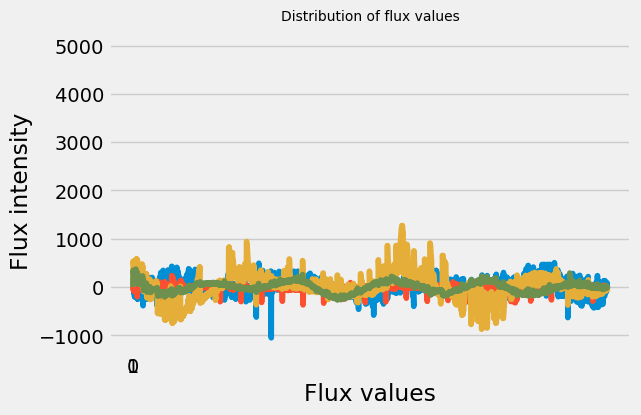

In [7]:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data_red, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data_red.iloc[0,])
plt.plot(train_data_red.iloc[1,])
plt.plot(train_data_red.iloc[2,])
plt.plot(train_data_red.iloc[3,])
plt.show()

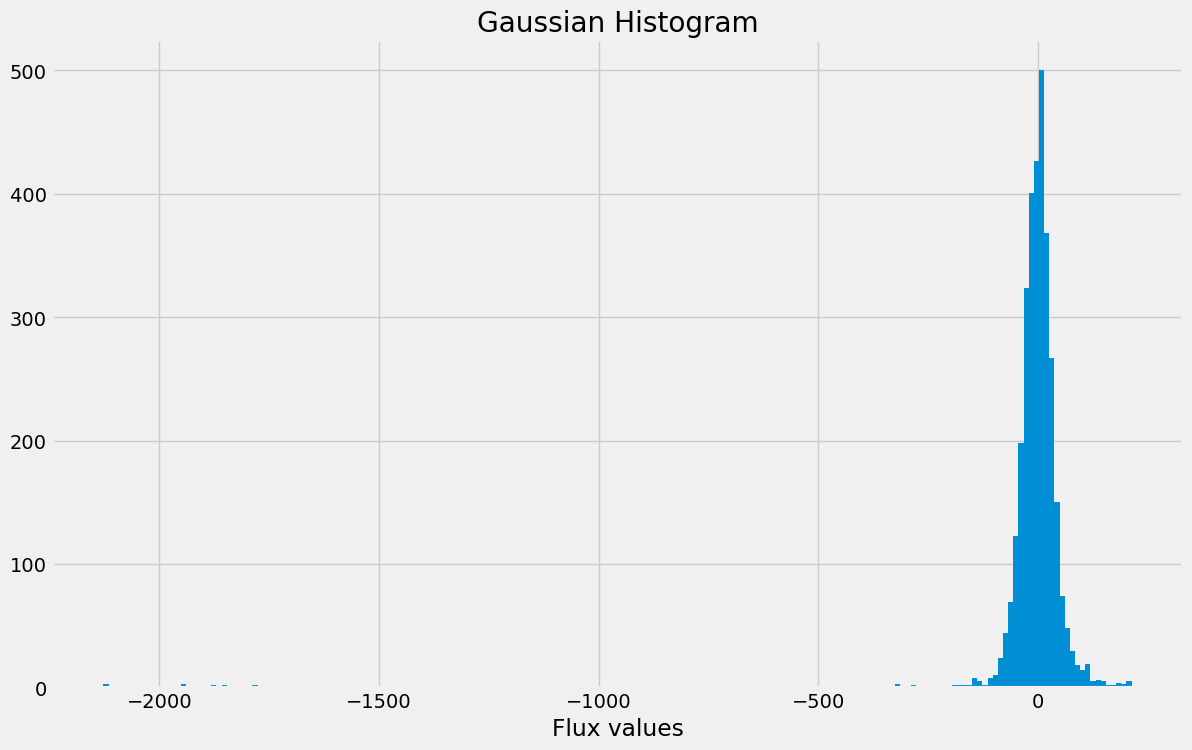

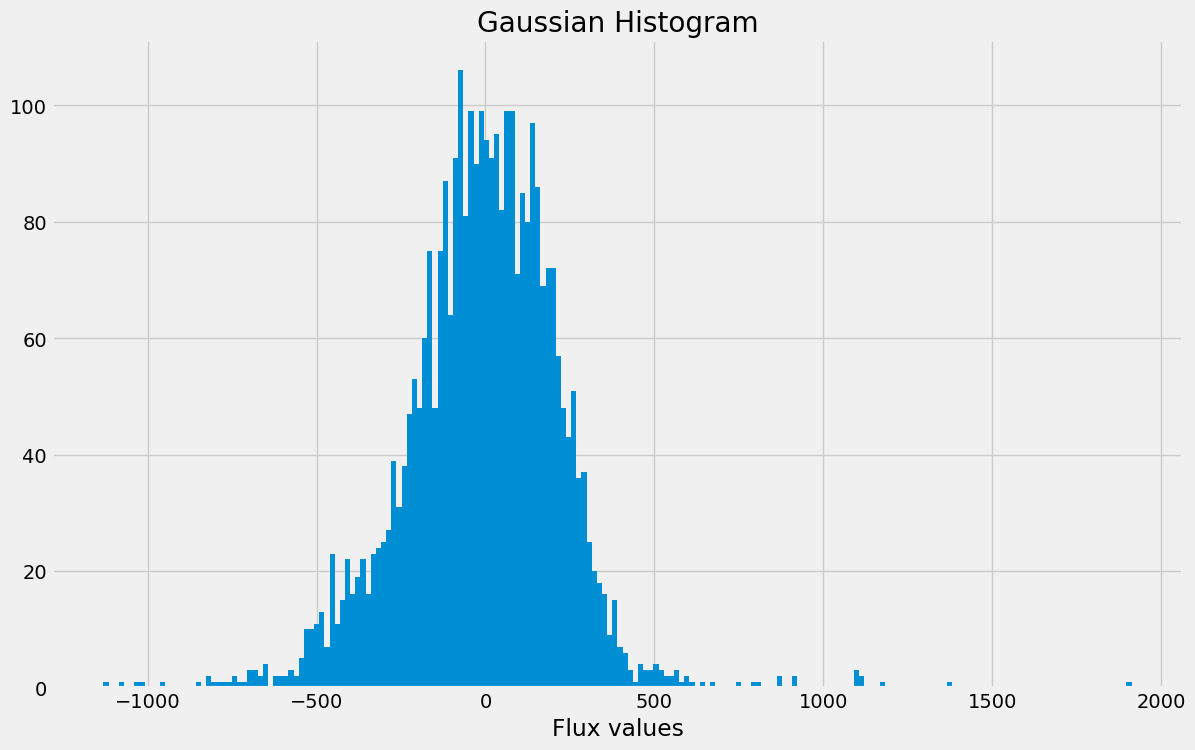

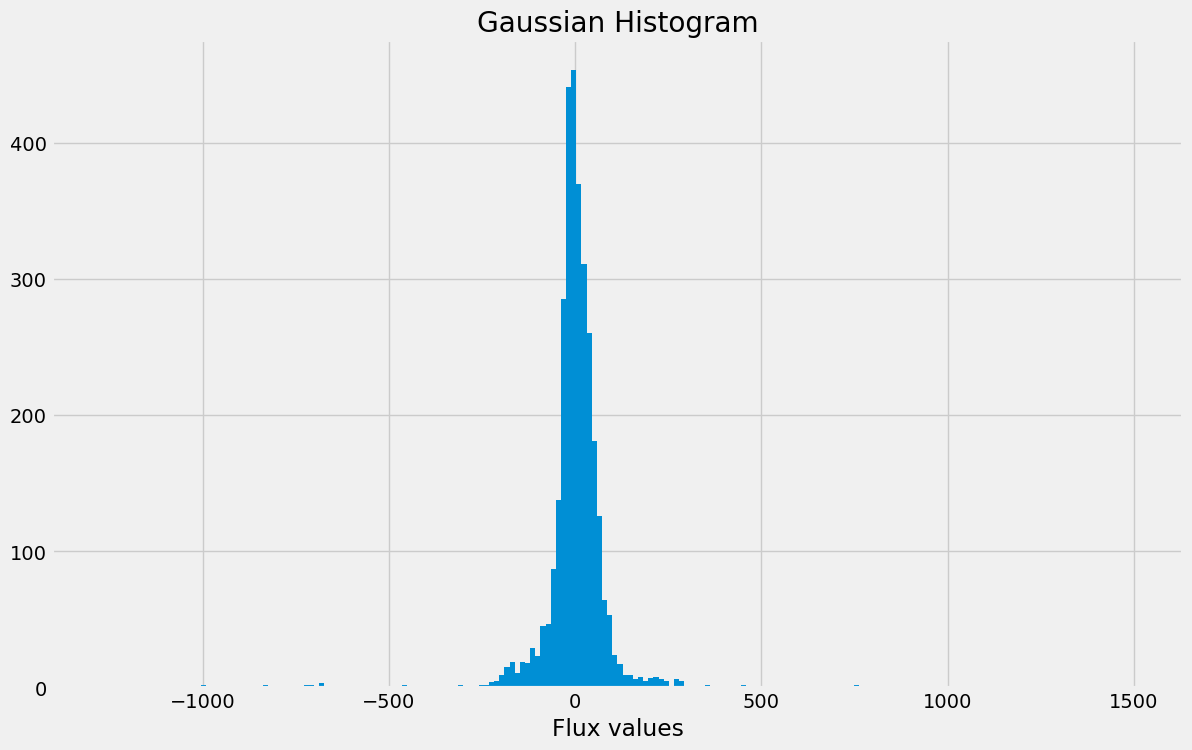

In [8]:
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data_red.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

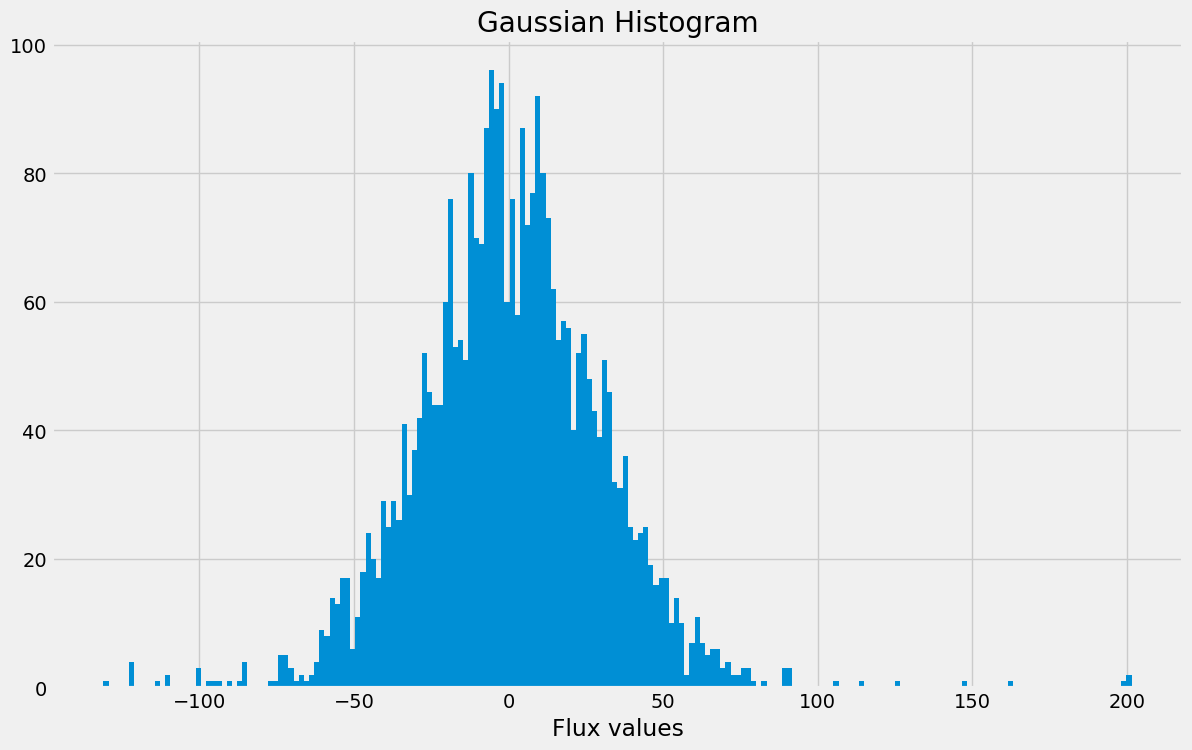

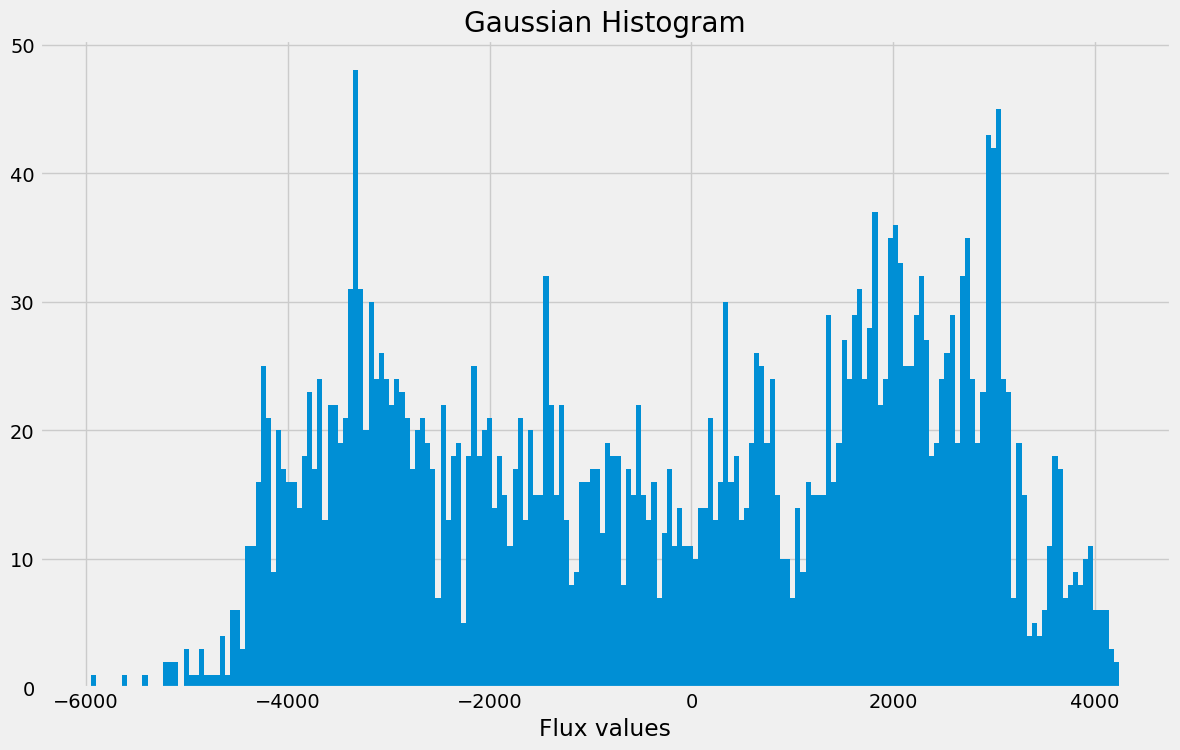

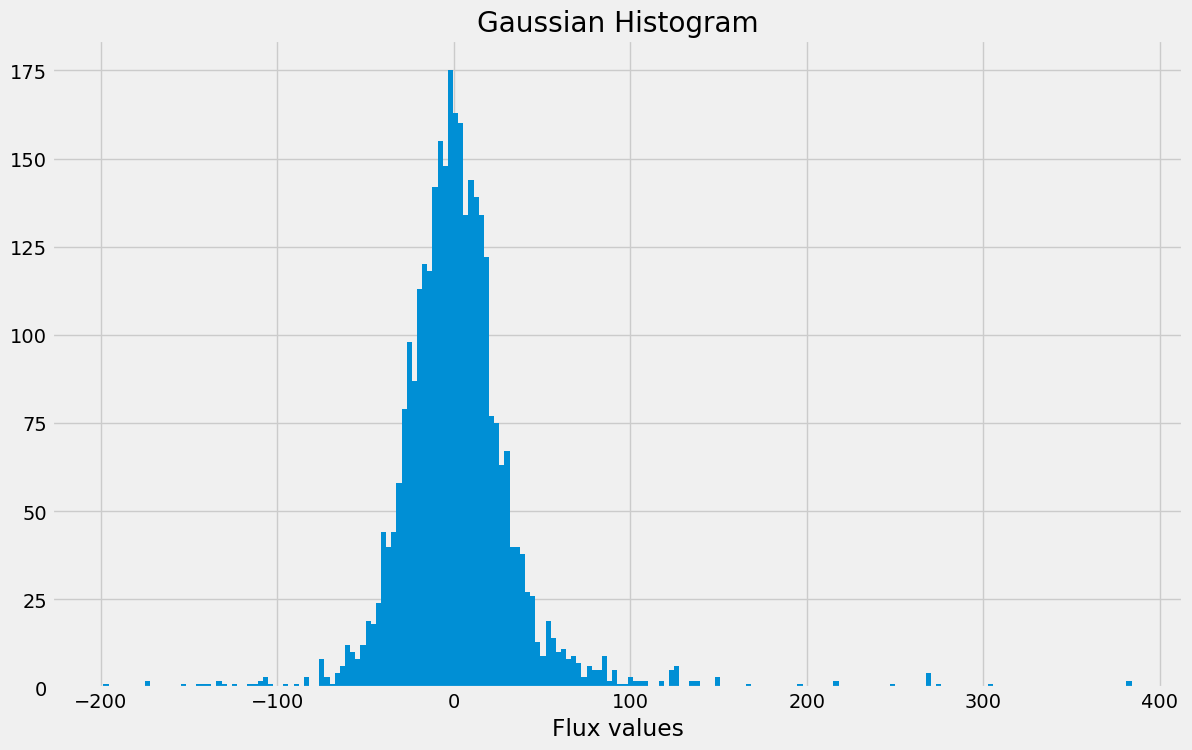

In [9]:
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data_red.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [10]:
x_train = train_data_red.drop(["LABEL"],axis=1)
y_train = train_data_red["LABEL"]   
x_test = test_data_red.drop(["LABEL"],axis=1)
y_test = test_data_red["LABEL"]

In [11]:
#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)


In [12]:
#Scaling the data
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)


In [13]:
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

37


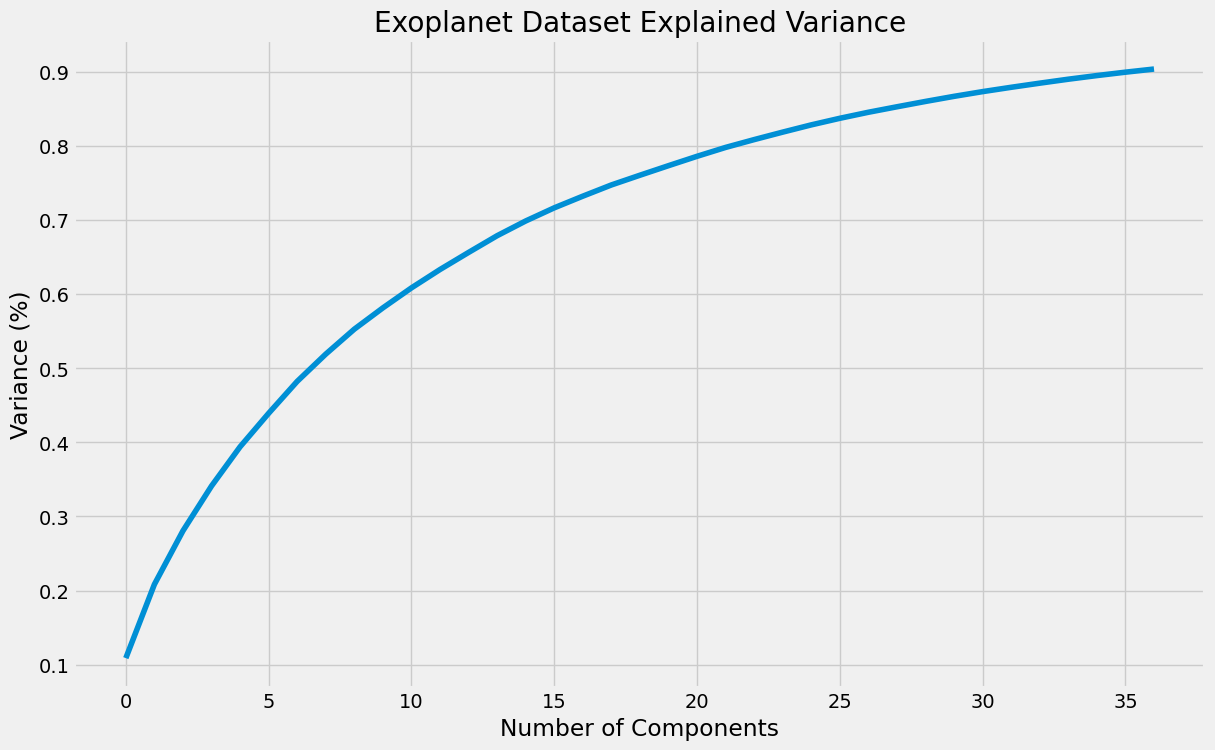

In [14]:
pca = PCA(n_components=k)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 



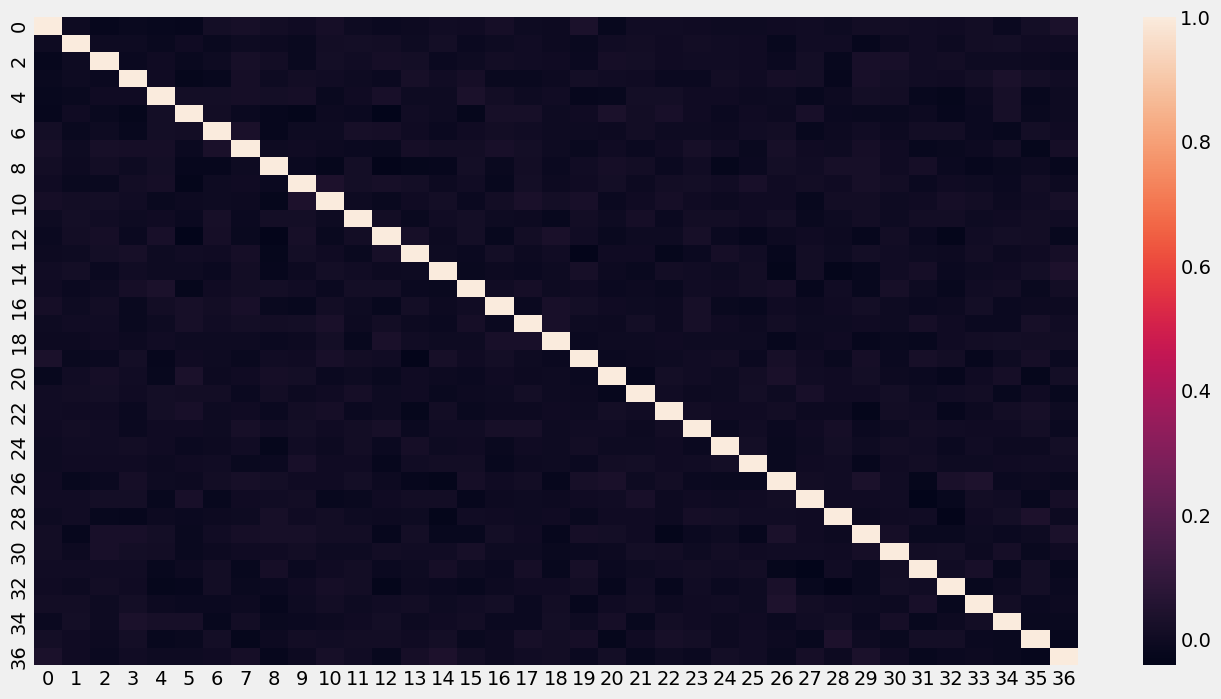

In [15]:
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=False)
df.columns
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

In [16]:
sm = SMOTE(random_state=27)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel()) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


In [17]:
classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

Accuracy mean: 0.8836633682250976
Accuracy variance: 0.16048891916533556
